In [27]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

In [2]:
import jax
import jax.numpy as jnp

from jax import random
main_rng = random.PRNGKey(42)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
import flax
from flax import linen as nn

In [4]:
def scaled_dot_product(q, k, v, mask=None):

    sequence_length_q = q.shape[-2]
    sequence_length_k = k.shape[-2]
    sequence_length_v = v.shape[-2]
    assert sequence_length_q==sequence_length_v, \
        "Queries and values must have the same sequence length."
    assert sequence_length_k==sequence_length_v, \
        "Keys and values must have the same sequence length."

    hidden_dimensionality_q = q.shape[-1]
    hidden_dimensionality_k = k.shape[-1]
    assert hidden_dimensionality_q==hidden_dimensionality_k, \
        "Queries and keys must have the same hidden dimensionality."
    
    # Scaled attention logits
    matmul_qk = jnp.matmul(q, jnp.swapaxes(k, -2, -1))
    scaled_attention_logits = matmul_qk / math.sqrt(hidden_dimensionality_k)

    # Apply mask
    if mask is not None:
        scaled_attention_logits = jnp.where(condition=mask==0, x=-1e9, y=scaled_attention_logits)
    
    # Softmax
    attention_weights = nn.softmax(scaled_attention_logits, axis=-1)
    
    # Weighted sum of values
    weighted_sum_of_values = jnp.matmul(attention_weights, v)
    
    return weighted_sum_of_values, attention_weights

In [5]:
seq_len, d_k = 3, 2
_, rand1 = random.split(main_rng)
qkv = random.normal(rand1, (3, seq_len, d_k))
q, k, v = qkv[0], qkv[1], qkv[2]
attention, values = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)


Q
 [[-0.6613315   0.70056266]
 [ 0.08239268 -1.7793142 ]
 [-0.04378588  1.0965251 ]]
K
 [[ 1.7257481   0.35568172]
 [ 1.3034704   1.2873708 ]
 [ 1.6871481  -0.5714404 ]]
V
 [[ 1.5129997   1.1050899 ]
 [ 0.27949408 -0.46224892]
 [-1.1003422  -1.1437944 ]]
Values
 [[0.27963293 0.54049295 0.17987415]
 [0.22194658 0.06706189 0.7109916 ]
 [0.27977085 0.5837308  0.13649832]]
Attention
 [[ 0.376226   -0.1465618 ]
 [-0.42778558 -0.5989566 ]
 [ 0.43624768 -0.11678301]]


In [6]:
def expand_mask(mask):
    """
    Expand the mask to four dimensions.
    Args:
        mask: Mask, in two, three, or four dimensions. The two last dimensions are (sequence_length, sequence_length).
        If 3D, the first dimension is (batch_size). If 4D, the two first dimensions are (batch_size, number_of_heads).

    Returns:
        Mask, in the shape (batch_size, number_of_heads, sequence_length, sequence_length).
    """
    
    assert mask.ndim >= 2, "Mask must have at least two dimensions (sequence_length, sequence_length)."
    assert mask.ndim <= 4, "Mask must have at most four dimensions (batch_size, number_of_heads, sequence_length, sequence_length)."

    # Broadcast over (number_of_heads)
    if mask.ndim == 3:
        mask = jnp.expand_dims(mask, axis=1)

    # Broadcast over (batch_size), then (number_of_heads)
    while mask.ndim < 4:
        mask = jnp.expand_dims(mask, axis=0)

    return mask

In [7]:
class MultiheadAttention(nn.Module):
    embedding_dimensionality : int
    number_of_heads : int

    def setup(self):
        
        self.qkv_projection = nn.Dense(
            3*self.embedding_dimensionality,
            kernel_init=nn.initializers.xavier_uniform(),
            bias_init=nn.initializers.zeros)

        self.w_o_projection = nn.Dense(
            self.embedding_dimensionality,
            kernel_init=nn.initializers.xavier_uniform(),
            bias_init=nn.initializers.zeros)

    def __call__(self, x, mask=None):
        
        batch_size, sequence_length, embedding_dimensionality = x.shape
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_projection(x)

        qkv = qkv.reshape(batch_size, sequence_length, self.number_of_heads, -1)
        qkv = qkv.transpose(0, 2, 1, 3)
        q, k, v = jnp.array_split(qkv, indices_or_sections=3, axis=-1)

        weighted_sum_of_values, attention_weights = scaled_dot_product(q, k, v, mask=mask)
        weighted_sum_of_values = weighted_sum_of_values.transpose(0, 2, 1, 3)
        weighted_sum_of_values = weighted_sum_of_values.reshape(batch_size, sequence_length, embedding_dimensionality)
        w_o = self.w_o_projection(weighted_sum_of_values)

        return w_o, attention_weights



In [8]:
## Test MultiheadAttention implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create attention
mh_attn = MultiheadAttention(embedding_dimensionality=128, number_of_heads=4)
# Initialize parameters of attention with random key and inputs
main_rng, init_rng = random.split(main_rng)
params = mh_attn.init(init_rng, x)['params']
# Apply attention with parameters on the inputs
out, attn = mh_attn.apply({'params': params}, x)
print('Out', out.shape, 'Attention', attn.shape)

del mh_attn, params

Out (3, 16, 128) Attention (3, 4, 16, 16)


In [11]:
class EncoderBlock(nn.Module):
    input_dimensionality : int
    number_of_heads : int
    dimensionality_feedforward : int
    dropout_probability : float

    def setup(self):
        self.self_attention = MultiheadAttention(
            embedding_dimensionality=self.input_dimensionality,
            number_of_heads=self.number_of_heads)
            
        self.linear = [
            nn.Dense(self.dimensionality_feedforward),
            nn.Dropout(self.dropout_probability),
            nn.relu,
            nn.Dense(self.input_dimensionality)]
            
        self.layer_normalization_1 = nn.LayerNorm()
        self.layer_normalization_2 = nn.LayerNorm()
        self.dropout = nn.Dropout(self.dropout_probability)

    def __call__(self, x, mask=None, train=True):

        # Attention
        attention_out, _ = self.self_attention(x, mask=mask)
        x = x + self.dropout(attention_out, deterministic=not train)
        x = self.layer_normalization_1(x)

        # Feed-forward
        linear_out = x
        for l in self.linear:
            linear_out = l(linear_out) if not isinstance(l, nn.Dropout) else l(linear_out, deterministic=not train)
        x = x + self.dropout(linear_out, deterministic=not train)
        x = self.layer_normalization_2(x)

        return x

In [12]:
## Test EncoderBlock implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create encoder block
encblock = EncoderBlock(input_dimensionality=128, number_of_heads=4, dimensionality_feedforward=512, dropout_probability=0.1)
# Initialize parameters of encoder block with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = encblock.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
# Apply encoder block with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
out = encblock.apply({'params': params}, x, train=True, rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)

del encblock, params

Out (3, 16, 128)


In [13]:
class TransformerEncoder(nn.Module):

    number_of_layers : int
    input_dimensionality : int
    number_of_heads : int
    dimensionality_feedforward : int
    dropout_probability : float

    def setup(self):
        self.layers = [EncoderBlock(self.input_dimensionality, self.number_of_heads, self.dimensionality_feedforward, self.dropout_probability) for _ in range(self.number_of_layers)]

    def __call__(self, x, mask=None, train=True):    
        for l in self.layers:
            x = l(x, mask=mask, train=train)
        return x

    def get_attention_maps(self, x, mask=None, train=True):        
        attention_maps = []
        for l in self.layers:
            _, attention_map = l.self_attention(x, mask=mask)
            attention_maps.append(attention_map)
            x = l(x, mask=mask, train=train)
        return attention_maps

In [14]:
## Test TransformerEncoder implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create Transformer encoder
transenc = TransformerEncoder(number_of_layers=5,
                              input_dimensionality=128,
                              number_of_heads=4,
                              dimensionality_feedforward=256,
                              dropout_probability=0.15)
# Initialize parameters of transformer with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transenc.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
# Apply transformer with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transenc.bind({'params': params}, rngs={'dropout': dropout_apply_rng})
out = binded_mod(x, train=True)
print('Out', out.shape)
attn_maps = binded_mod.get_attention_maps(x, train=True)
print('Attention maps', len(attn_maps), attn_maps[0].shape)

del transenc, binded_mod, params

Out (3, 16, 128)
Attention maps 5 (3, 4, 16, 16)


In [24]:
class PositionalEncoding(nn.Module):

    hidden_dimensionality : int
    maximum_sequence_length : int = 5000

    def setup(self):
        positional_encoding = np.zeros((self.maximum_sequence_length, self.hidden_dimensionality))
        position = np.arange(0, self.maximum_sequence_length, dtype=np.float32)[:,None]
        denominator = np.exp(np.arange(0, self.hidden_dimensionality, 2) * (-math.log(10000.0) / self.hidden_dimensionality))
        positional_encoding[:, 0::2] = np.sin(position * denominator)
        positional_encoding[:, 1::2] = np.cos(position * denominator)
        positional_encoding = positional_encoding[None]
        self.positional_encoding = jax.device_put(positional_encoding)

    def __call__(self, x):
        x = x + self.positional_encoding[:, :x.positional_encoding[1]]
        return x

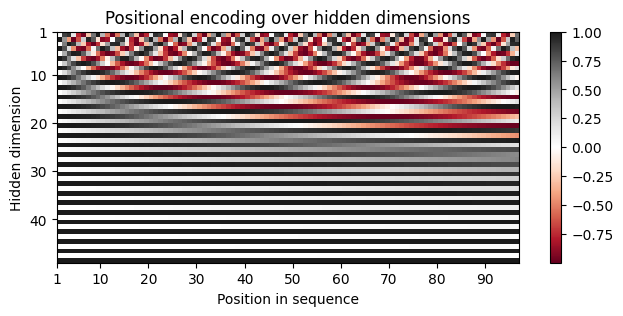

In [25]:
# Create encoding block, bind to access positional encoding (module has no parameters)
encod_block = PositionalEncoding(hidden_dimensionality=48, maximum_sequence_length=96).bind({})
# Obtain positional encodings as numpy array
pe = jax.device_get(encod_block.positional_encoding.squeeze().T)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

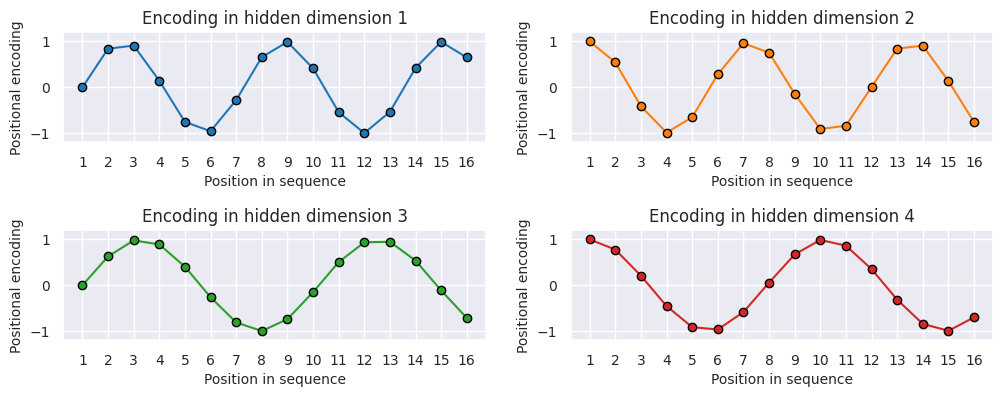

In [28]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

In [29]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)